In [21]:
%pip install python-dotenv

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In the notebook eda, I did some simple work with the mortality dataset and then used the NPS API to get park codes that matched the park name for each death. Now, I'm going to start with that dataset to get even more info from the NPS API.

In [4]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import requests, time

from dotenv import load_dotenv

import os

Load API key from .env

In [5]:
load_dotenv()

API_KEY = os.getenv("NPS_API_KEY")

print(API_KEY is not None)

True


In [6]:
df = pd.read_csv("../data/mortality_with_parks.csv")

df.head()

,Incident Date,Park Name,Cause of Death,Cause of Death Group \n(Used in the NPS Mortality Dashboard),Intent,Outcome,Sex,Age Range,Activity,parkCode,fullName_official,skip_api
0,2007-01-01,Glen Canyon National Recreation Area,Undetermined,Undetermined,Undetermined,Fatal injury,Male,65+,Not Reported,glca,Glen Canyon National Recreation Area,False
1,2007-01-22,Golden Gate National Recreation Area,Drowning,Drowning,Unintentional,Fatal injury,Male,Not Reported,Vessel Related,goga,Golden Gate National Recreation Area,False
2,2007-01-22,Golden Gate National Recreation Area,Undetermined,Undetermined,Undetermined,Fatal injury,Male,Not Reported,Vessel Related,goga,Golden Gate National Recreation Area,False
3,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Motor Vehicle Crash,Unintentional,Fatal injury,Female,15-24,Driving,natr,Natchez Trace Parkway,False
4,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Motor Vehicle Crash,Unintentional,Fatal injury,Female,45-54,Driving,natr,Natchez Trace Parkway,False


I need the year of each event to lookup the visitor statistics for that year. I'm going to pull it out of the incident date column. I want some more info about that column first.

In [7]:
print(df["Incident Date"].dtype)

object


The date is currently an object -- a string in this case -- so I'm going to convert it to datetime.

In [8]:
df["Incident Date"] = pd.to_datetime(df["Incident Date"], errors="coerce")


run this line again to confirm that it was changed correctly.

In [9]:
print(df["Incident Date"].dtype)

datetime64[ns]


Check to see if there are any missing dates.

In [10]:
print(df["Incident Date"].isna().sum())

0


Next, I'm going to build the dataframe I need to request from the API -- that park code and incident year for every row that has a park code, and no rows that do not.

In [11]:
pairs = (
    #filter out rows that don't have a park code
    df.loc[df["parkCode"].notna(), ["parkCode", "Incident Date"]]
    #Pull the calendar year into a new column to search for annual data
      .assign(year=lambda d: d["Incident Date"].dt.year.astype(int))
    #drop duplicates since I can match data to all lines with the same code and year
      .drop_duplicates(subset=["parkCode", "year"])
      .reset_index(drop=True)
)

#Print length of the new dataframe and the first few lines to make sure the info is correct
print("Unique (parkCode, year) pairs:", len(pairs))
pairs.head()

Unique (parkCode, year) pairs: 1340


,parkCode,Incident Date,year
0,glca,2007-01-01,2007
1,goga,2007-01-22,2007
2,natr,2007-01-29,2007
3,gate,2007-02-07,2007
4,blca,2007-02-10,2007


In [19]:
def fetch_annual_visits(unit_code: str, year: int, pause: float = 0.25,
                        base: str = "https://irmaservices.nps.gov/v3/rest/stats/visitation") -> dict | None:
    """
    Fetch monthly visitation for a park/year and return annual totals
    for RecreationVisitors and NonRecreationVisitors. Handles either
    capitalized or lower_snake column names.
    """


    params = {
        "unitCodes": unit_code,
        "startMonth": 1, "startYear": year,
        "endMonth": 12, "endYear": year,
        "format": "json",
    }
    try:
        r = requests.get(base, params=params, headers={"Accept": "application/json"}, timeout=30)
        r.raise_for_status()
        rows = r.json()
        if not rows:
            time.sleep(pause)
            return None

        dfm = pd.DataFrame(rows)

        # Normalize column names to a common set we can sum
        cols = {c.lower(): c for c in dfm.columns}  # map lowercase -> actual
        rec_col = cols.get("recreationvisitors") or cols.get("recreationvisits")
        nonrec_col = cols.get("nonrecreationvisitors") or cols.get("nonrecreationvisits")

        rec = int(dfm[rec_col].fillna(0).sum()) if rec_col in dfm.columns else None
        nonrec = int(dfm[nonrec_col].fillna(0).sum()) if nonrec_col in dfm.columns else None

        time.sleep(pause)
        return {"recreationVisits": rec, "nonRecreationVisits": nonrec}

    except requests.HTTPError as e:
        print(f"[HTTP {getattr(e.response,'status_code','?')}] {unit_code} {year}: {e}")
        time.sleep(pause)
        return None
    except Exception as e:
        print(f"[Error] {unit_code} {year}: {e}")
        time.sleep(pause)
        return None


In [20]:
print(fetch_annual_visits("grca", 2019))
# Expected shape: {'recreationVisits': <big int>, 'nonRecreationVisits': <int>}


{'recreationVisits': 5974411, 'nonRecreationVisits': 21249}


In [21]:
cache = {}
records = []

for i, (code, yr) in enumerate(pairs[["parkCode", "year"]].itertuples(index=False, name=None), start=1):
    key = (str(code), int(yr))

    if key in cache:
        result = cache[key]
    else:
        result = fetch_annual_visits(key[0], key[1], pause=0.25)
        cache[key] = result

    if result is not None:
        records.append({
            "parkCode": key[0],
            "year": key[1],
            "recreationVisits": result["recreationVisits"],
            "nonRecreationVisits": result["nonRecreationVisits"],
        })
    else:
        records.append({
            "parkCode": key[0],
            "year": key[1],
            "recreationVisits": None,
            "nonRecreationVisits": None,
        })

    if i % 25 == 0:
        print(f"Fetched {i} / {len(pairs)}")

df_visits = pd.DataFrame(records)
print("Done. Rows fetched:", len(df_visits))
df_visits.head()


Fetched 25 / 1340
Fetched 50 / 1340
Fetched 75 / 1340
Fetched 100 / 1340
Fetched 125 / 1340
Fetched 150 / 1340
Fetched 175 / 1340
Fetched 200 / 1340
Fetched 225 / 1340
Fetched 250 / 1340
Fetched 275 / 1340
Fetched 300 / 1340
Fetched 325 / 1340
Fetched 350 / 1340
Fetched 375 / 1340
Fetched 400 / 1340
Fetched 425 / 1340
Fetched 450 / 1340
Fetched 475 / 1340
Fetched 500 / 1340
Fetched 525 / 1340
Fetched 550 / 1340
Fetched 575 / 1340
Fetched 600 / 1340
Fetched 625 / 1340
Fetched 650 / 1340
Fetched 675 / 1340
Fetched 700 / 1340
Fetched 725 / 1340
Fetched 750 / 1340
Fetched 775 / 1340
Fetched 800 / 1340
Fetched 825 / 1340
Fetched 850 / 1340
Fetched 875 / 1340
Fetched 900 / 1340
Fetched 925 / 1340
Fetched 950 / 1340
Fetched 975 / 1340
Fetched 1000 / 1340
Fetched 1025 / 1340
Fetched 1050 / 1340
Fetched 1075 / 1340
Fetched 1100 / 1340
Fetched 1125 / 1340
Fetched 1150 / 1340
Fetched 1175 / 1340
Fetched 1200 / 1340
Fetched 1225 / 1340
Fetched 1250 / 1340
Fetched 1275 / 1340
Fetched 1300 / 1340
Fe

,parkCode,year,recreationVisits,nonRecreationVisits
0,glca,2007,1894114.0,19306.0
1,goga,2007,14397313.0,0.0
2,natr,2007,5777666.0,7248237.0
3,gate,2007,8813204.0,1358523.0
4,blca,2007,219576.0,0.0


In [23]:
# Save the visits dataframe to a CSV
output_path = "annual_visits.csv"
df_visits.to_csv(output_path, index=False)

print(f"CSV file saved to {output_path}")


CSV file saved to annual_visits.csv


In [25]:
print(df.columns.tolist())
df.head()


['Incident Date', 'Park Name', 'Cause of Death', 'Cause of Death Group \n(Used in the NPS Mortality Dashboard) ', 'Intent', 'Outcome', 'Sex', 'Age Range', 'Activity', 'parkCode', 'fullName_official', 'skip_api']


,Incident Date,Park Name,Cause of Death,Cause of Death Group \n(Used in the NPS Mortality Dashboard),Intent,Outcome,Sex,Age Range,Activity,parkCode,fullName_official,skip_api
0,2007-01-01,Glen Canyon National Recreation Area,Undetermined,Undetermined,Undetermined,Fatal injury,Male,65+,Not Reported,glca,Glen Canyon National Recreation Area,False
1,2007-01-22,Golden Gate National Recreation Area,Drowning,Drowning,Unintentional,Fatal injury,Male,Not Reported,Vessel Related,goga,Golden Gate National Recreation Area,False
2,2007-01-22,Golden Gate National Recreation Area,Undetermined,Undetermined,Undetermined,Fatal injury,Male,Not Reported,Vessel Related,goga,Golden Gate National Recreation Area,False
3,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Motor Vehicle Crash,Unintentional,Fatal injury,Female,15-24,Driving,natr,Natchez Trace Parkway,False
4,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Motor Vehicle Crash,Unintentional,Fatal injury,Female,45-54,Driving,natr,Natchez Trace Parkway,False


In [26]:
# filter rows where Cause of Death mentions "drown"
drowning = df[df["Cause of Death"].str.contains("drown", case=False, na=False)]


In [27]:
# count how many drowning rows per parkCode
top15_parks = (
    drowning.groupby("parkCode")
    .size()
    .sort_values(ascending=False)
    .head(15)
    .index
)

print("Top 15 drowning parks:", list(top15_parks))


Top 15 drowning parks: ['lake', 'caha', 'glca', 'chat', 'dewa', 'neri', 'guis', 'goga', 'gate', 'indu', 'upde', 'grca', 'buff', 'yose', 'pore']


In [28]:
visits_top15 = df_visits[df_visits["parkCode"].isin(top15_parks)]


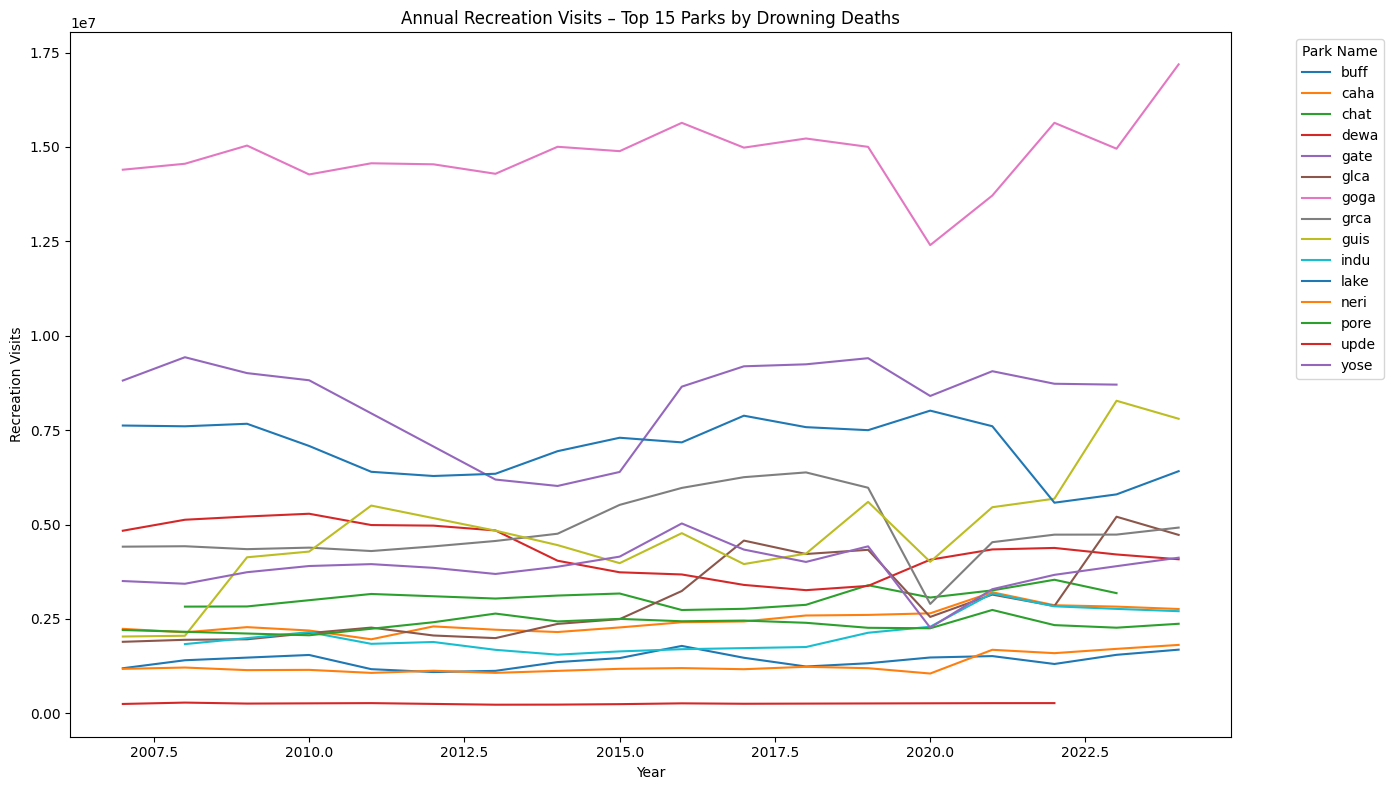

In [31]:
plt.figure(figsize=(14,8))

for park, grp in visits_top15.groupby("parkCode"):
    plt.plot(grp["year"], grp["recreationVisits"], label=park)

plt.title("Annual Recreation Visits – Top 15 Parks by Drowning Deaths")
plt.xlabel("Year")
plt.ylabel("Recreation Visits")
plt.legend(title="Park Name", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
